<a href="https://colab.research.google.com/github/gremlin97/Detecting-and-refining-HiRISE-Image-Patches-Obscured-by-Atmospheric-Dust/blob/main/Denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%mkdir dataset
!cp '/content/drive/MyDrive/rdr_nomap_browse.zip' dataset/
%cd dataset

/content/dataset


In [4]:
!unzip -q rdr_nomap_browse.zip 
%cd rdr_nomap_browse

/content/dataset/rdr_nomap_browse


In [5]:
import os
import random
from skimage import io
from collections import Counter
import matplotlib as plt
import pandas as pd

path = '/content/dataset/rdr_nomap_browse'
data = '/content/dataset/rdr_nomap_browse/manifest.csv'
path_dusty = '/content/dataset/rdr_nomap_browse/dusty'
path_not_dusty = '/content/dataset/rdr_nomap_browse/not_dusty'

df = pd.read_csv(data)
os.listdir(path_dusty)
path

'/content/dataset/rdr_nomap_browse'

In [6]:
df.sample(10)

,#dataset,id,label
697,train,009172_PSP_002882_2485_r1440_c512,dusty
8932,train,009253_PSP_003424_0955_r5633_c1331,not_dusty
1818,train,000203_PSP_002882_2485_r4997_c1229,dusty
1934,train,008332_PSP_004330_1410_r3114_c922,dusty
1200,train,004934_PSP_004325_1415_r6736_c717,dusty
1967,train,004916_PSP_004813_1450_r5226_c1741,dusty
12758,validation,006293_PSP_002455_2360_r804_c1434,not_dusty
18657,test,006658_PSP_003687_1515_r557_c614,not_dusty
3885,train,004888_ESP_019869_1405_r969_c102,dusty
5523,train,001587_ESP_023695_1460_r2952_c922,not_dusty


In [7]:
Xtrain_list = []
Ytrain_list = []

for i in df.index:
  if df['#dataset'][i] == 'train' and df['label'][i] == 'not_dusty':
    Xtrain_list.append({'id':df['id'][i]})
    Ytrain_list.append({'label':df['label'][i]})

In [8]:
from skimage import io

# p = '/content/dataset/rdr_nomap_browse/not_dusty/'

Xtrain = []

curr_dir = os.getcwd()

for x in Xtrain_list:
  Xtrain.append(io.imread(curr_dir + '/' + 'not_dusty' + '/' + x['id'] + '.png'))

In [9]:
from collections import Counter
print(len(Xtrain))

4961


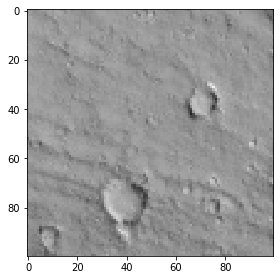

In [10]:
io.imshow(Xtrain[4000])

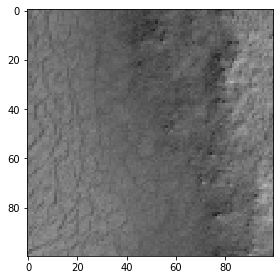

In [11]:
io.imshow(Xtrain[1102])

In [12]:
norm = np.max(Xtrain)-np.min(Xtrain)
for i in range(len(Xtrain)):
  Xtrain[i] = Xtrain[i]/norm

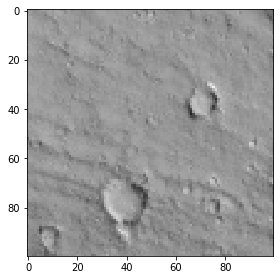

In [13]:
io.imshow(Xtrain[4000])

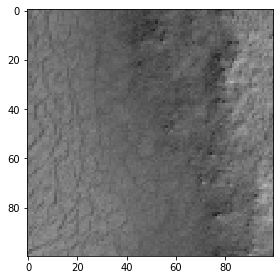

In [14]:
io.imshow(Xtrain[1102])

In [15]:
import random
import cv2

def add_noise(img):

	# Getting the dimensions of the image
	row , col = img.shape
	
	# Randomly pick some pixels in the
	# image for coloring them white
	# Pick a random number between 300 and 10000
	number_of_pixels = random.randint(30, 100)
	for i in range(number_of_pixels):
	
		# Pick a random y coordinate
		y_coord=random.randint(0, row - 1)
		
		# Pick a random x coordinate
		x_coord=random.randint(0, col - 1)
		
		# Color that pixel to 205-255
		img[y_coord][x_coord] = np.random.randint(205,255)
		
	# Randomly pick some pixels in
	# the image for coloring them black
	# Pick a random number between 300 and 10000
	number_of_pixels = random.randint(30 , 100)
	for i in range(number_of_pixels):
	
		# Pick a random y coordinate
		y_coord=random.randint(0, row - 1)
		
		# Pick a random x coordinate
		x_coord=random.randint(0, col - 1)
		
		# Color that pixel to 0-50
		img[y_coord][x_coord] = np.random.randint(0,50)
		
	return img

In [16]:
np.random.randint(205,255), np.random.randint(0,50)

(209, 7)

In [17]:
from skimage import img_as_ubyte

NoisyX= []

for x in Xtrain:
  img = img_as_ubyte(x)
  img = add_noise(img)
  NoisyX.append(img)

In [18]:
NoisyX[0].shape

(100, 100)

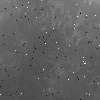

In [19]:
from google.colab.patches import cv2_imshow
cv2_imshow(NoisyX[3])

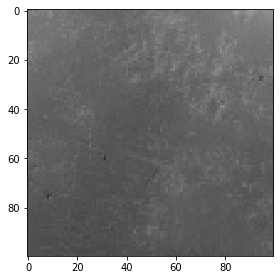

In [20]:
io.imshow(Xtrain[3])

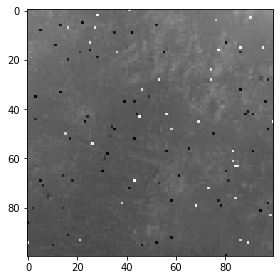

In [21]:
io.imshow(NoisyX[3])

In [22]:
X_train = np.array(Xtrain)
NoisyX = np.array(NoisyX)

In [23]:
X_train = X_train.reshape(len(X_train),100,100,1)
NoisyX = NoisyX.reshape(len(NoisyX),100,100,1)

In [24]:
X_train.shape

(4961, 100, 100, 1)

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [26]:
input = layers.Input(shape=(100, 100, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 32)       9248  

In [27]:
autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=100,
    batch_size=64,
    shuffle=True
)

Epoch 1/100
78/78 [==============================] - 12s 46ms/step - loss: 0.6469
Epoch 2/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6208
Epoch 3/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6196
Epoch 4/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6189
Epoch 5/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6186
Epoch 6/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6185
Epoch 7/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6181
Epoch 8/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6181
Epoch 9/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6179
Epoch 10/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6178
Epoch 11/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6177
Epoch 12/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6177
Epoch 13/100
78/78 [====

In [28]:
predictions = autoencoder.predict(X_train)

156/156 [==============================] - 2s 9ms/step


In [29]:
preds = predictions[5].reshape(100,100)

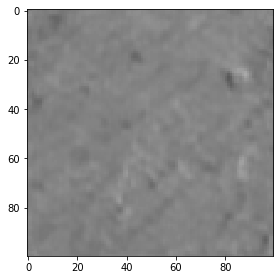

In [30]:
io.imshow(preds)

In [31]:
autoencoder.fit(
    x=NoisyX,
    y=X_train,
    epochs=100,
    batch_size=64,
    shuffle=True
)

Epoch 1/100
78/78 [==============================] - 3s 40ms/step - loss: 7.6992
Epoch 2/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6872
Epoch 3/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6870
Epoch 4/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6868
Epoch 5/100
78/78 [==============================] - 3s 40ms/step - loss: 0.6867
Epoch 6/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6865
Epoch 7/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6863
Epoch 8/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6859
Epoch 9/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6856
Epoch 10/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6852
Epoch 11/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6849
Epoch 12/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6844
Epoch 13/100
78/78 [=====

156/156 [==============================] - 1s 9ms/step


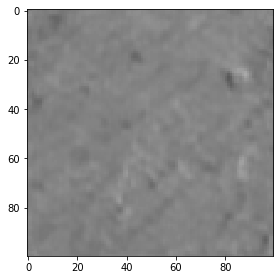

In [32]:
predictions_n = autoencoder.predict(NoisyX)
preds_n = predictions_n[5].reshape(100,100)
io.imshow(preds)

In [33]:
import random
import cv2

def add_noise_prm(img, l, h):

	# Getting the dimensions of the image
	row , col = img.shape
	
	# Randomly pick some pixels in the
	# image for coloring them white
	# Pick a random number between l and h
	number_of_pixels = random.randint(l, h)
	for i in range(number_of_pixels):
	
		# Pick a random y coordinate
		y_coord=random.randint(0, row - 1)
		
		# Pick a random x coordinate
		x_coord=random.randint(0, col - 1)
		
		# Color that pixel to 205-255
		img[y_coord][x_coord] = np.random.randint(155,255)
		
	# Randomly pick some pixels in
	# the image for coloring them black
	# Pick a random number between l and h
	number_of_pixels = random.randint(l , h)
	for i in range(number_of_pixels):
	
		# Pick a random y coordinate
		y_coord=random.randint(0, row - 1)
		
		# Pick a random x coordinate
		x_coord=random.randint(0, col - 1)
		
		# Color that pixel to 0-50
		img[y_coord][x_coord] = np.random.randint(0,100)
		
	return img

In [34]:
Dusty = []
for x in Xtrain:
  img = img_as_ubyte(x)
  img = add_noise_prm(img,400,500)
  Dusty.append(img)

In [35]:
Dusty = np.array(Dusty)
Dusty = Dusty.reshape(len(Dusty),100,100,1)
Dusty.shape

(4961, 100, 100, 1)

In [36]:
autoencoder.fit(
    x=Dusty,
    y=X_train,
    epochs=100,
    batch_size=64,
    shuffle=True
)

Epoch 1/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6265
Epoch 2/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6251
Epoch 3/100
78/78 [==============================] - 3s 42ms/step - loss: 0.6249
Epoch 4/100
78/78 [==============================] - 3s 40ms/step - loss: 0.6247
Epoch 5/100
78/78 [==============================] - 3s 40ms/step - loss: 0.6243
Epoch 6/100
78/78 [==============================] - 3s 42ms/step - loss: 0.6243
Epoch 7/100
78/78 [==============================] - 3s 42ms/step - loss: 0.6241
Epoch 8/100
78/78 [==============================] - 3s 40ms/step - loss: 0.6239
Epoch 9/100
78/78 [==============================] - 3s 40ms/step - loss: 0.6237
Epoch 10/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6236
Epoch 11/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6234
Epoch 12/100
78/78 [==============================] - 3s 41ms/step - loss: 0.6240
Epoch 13/100
78/78 [=====

156/156 [==============================] - 2s 11ms/step


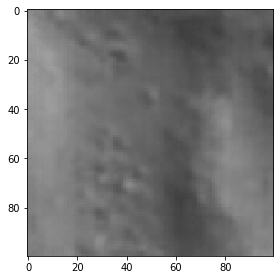

In [92]:
predictions_n = autoencoder.predict(NoisyX)
preds_n = predictions_n[6].reshape(100,100)
io.imshow(preds_n)

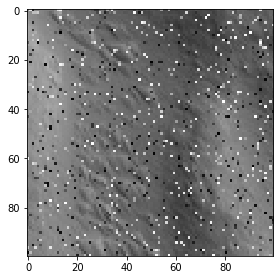

In [87]:
im_s = Dusty[6].reshape(100,100)
io.imshow(im_s)

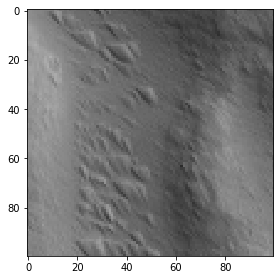

In [88]:
io.imshow(Xtrain[6])

In [93]:
from PIL import Image
pil_arr = []
for x in predictions_n:
  v = x.reshape(100,100)
  pil_arr.append(v)

In [96]:
from PIL import Image
pil_arr_train = []
for x in Xtrain:
  v = x.reshape(100,100)
  pil_arr_train.append(v)

In [104]:
from PIL import Image
pil_arr_noisy = []
for x in Dusty:
  v = x.reshape(100,100)
  pil_arr_noisy.append(v)

In [105]:
pil_arr = pil_arr[0:20]
pil_arr_train = pil_arr_train[0:20]
pil_arr_noisy = pil_arr_noisy[0:20]

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


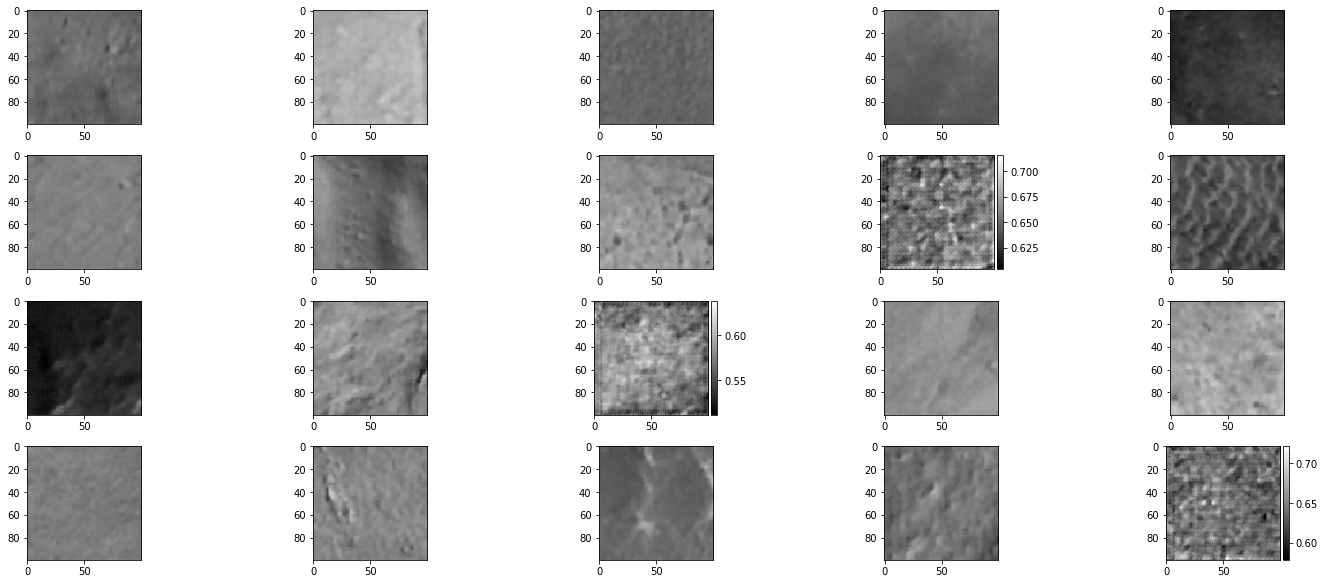

In [101]:
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(pil_arr):
  plt.subplot(len(pil_arr) / columns + 1, columns, i + 1)
  io.imshow(image, cmap='gray')

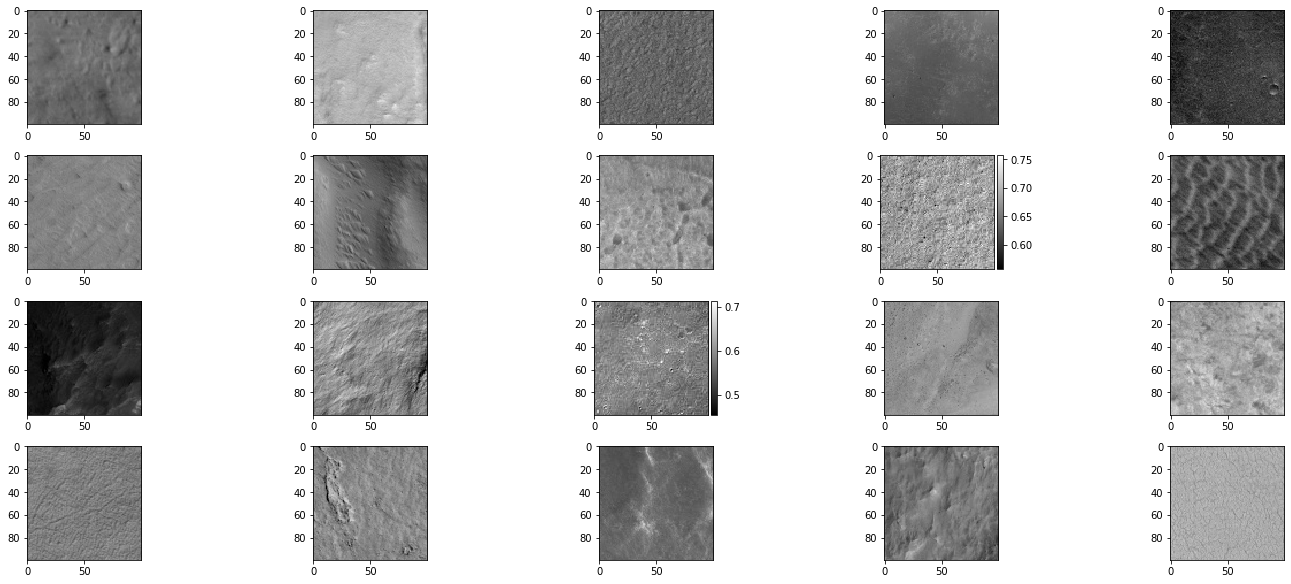

In [102]:
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(pil_arr_train):
  plt.subplot(len(pil_arr_train) / columns + 1, columns, i + 1)
  io.imshow(image, cmap='gray')

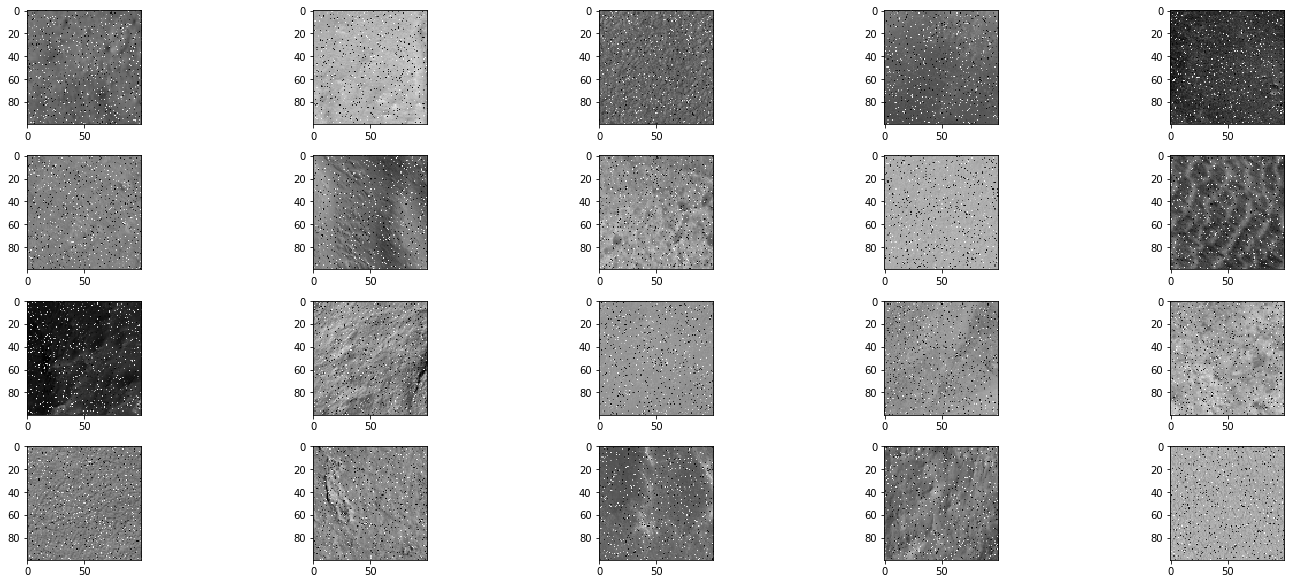

In [106]:
plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(pil_arr_noisy):
  plt.subplot(len(pil_arr_noisy) / columns + 1, columns, i + 1)
  io.imshow(image, cmap='gray')